In [1]:
import numpy as np
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV

import SparseSC
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector

# custom functions
from definitions import fake_num, show_plots, sign_level, save_figs, incl_years, incl_countries, stat, save_output, \
    date_col, target_var
from util_general import flatten, get_impl_date, get_table_path, get_months_cors
from util_estimation import arco_pivot, sc_pivot, transform_back, save_dataframe, did_pivot, save_results, \
    save_did
from plot_functions import plot_lasso_path, plot_cumsum, plot_predictions, plot_cumsum_impl

# custom functions
from definitions import all_paths, country_col, year_col, stat, incl_countries, incl_years, model_val
from util_general import read_data, validate_input, get_trans, get_data_path, get_impl_date
from estimators import arco, sc, did

In [154]:
timeframe = 'm'
model = 'arco'
treatment_country = 'france'
prox = False

alpha_min=0.01
alpha_max=1.0
alpha_step=0.001
ts_splits=5
lasso_iters=100000000
tol=0.00000001

In [155]:
# read data
df = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
df_stat = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}_{stat}')

df = df[(df[country_col].isin(incl_countries)) & (df[year_col].isin(incl_years))]
df_stat = df_stat[(df_stat[country_col].isin(incl_countries)) & (df_stat[year_col].isin(incl_years))]

# Initialize

In [156]:
tables_path_res = get_table_path(timeframe=timeframe, folder='results', country=treatment_country, model=model)

treatment_log_diff, donors_log_diff = arco_pivot(df=df_stat, treatment_country=treatment_country,
                                                     timeframe=timeframe, model=model, prox=prox)

y_log_diff = treatment_log_diff
X_log_diff = donors_log_diff

impl_date = get_impl_date(treatment_country=treatment_country)
impl_date_index = list(treatment_log_diff.index).index(impl_date)

months_cor = get_months_cors(model=model, timeframe=timeframe, treatment_country=treatment_country)
split_index = impl_date_index + months_cor
split_date = treatment_log_diff.index[split_index]

y_log_diff_pre = treatment_log_diff[treatment_log_diff.index < split_date]
X_log_diff_pre = donors_log_diff[donors_log_diff.index < split_date]
print(f'Treatment implementation date (T_0):        {impl_date}')
print(f'Treatment split date (T_0 cor):             {split_date}')
print(f'Nr of timeframes pre-treatment (t < T_0):   {len(X_log_diff_pre)}')
print(f'Nr of timeframes post-treatment (t >= T_0): {len(donors_log_diff) - len(X_log_diff_pre)}')
print("\n")

# Storing the fit object for later reference
SS = StandardScaler()
SS_treatmentfit_pre = SS.fit(np.array(y_log_diff_pre).reshape(-1, 1))
X_log_diff_stand = pd.DataFrame(SS.fit_transform(np.array(X_log_diff)), index=X_log_diff.index, columns=X_log_diff.columns)

# Generating the standardized values of X and y
X_log_diff_pre_stand = pd.DataFrame(SS.fit_transform(X_log_diff_pre), index=X_log_diff_pre.index, columns=X_log_diff_pre.columns)
y_log_diff_pre_stand = pd.DataFrame(SS.fit_transform(y_log_diff_pre), index=y_log_diff_pre.index, columns=y_log_diff_pre.columns)

Treatment implementation date (T_0):        2014-04-01
Treatment split date (T_0 cor):             2014-01-01
Nr of timeframes pre-treatment (t < T_0):   156
Nr of timeframes post-treatment (t >= T_0): 70




# LASSO

In [157]:
# # define model
# ts_split = TimeSeriesSplit(n_splits=ts_splits)

# lasso = LassoCV(
#     alphas=np.arange(alpha_min, alpha_max, alpha_step),
#     fit_intercept=True,
#     cv=ts_split,
#     max_iter=lasso_iters,
#     tol=tol,
#     n_jobs=-1,
#     random_state=0,
#     selection='random'
# )

# # fit model
# lasso.fit(X_log_diff_pre_stand, y_log_diff_pre_stand[target_var])
# # lasso results
# r2_pre_log_diff_stand = lasso.score(X_log_diff_pre_stand, y_log_diff_pre_stand)
# lasso_alpha = lasso.alpha_
# print(f'R2 r2_pre_log_diff_stand: {r2_pre_log_diff_stand}')
# print(f'alpha: {lasso_alpha}')

# coefs = list(lasso.coef_)
# coefs_index = [i for i, val in enumerate(coefs) if val != 0]
# n_pars = len(coefs_index)
# lasso_pars = list(donors_log_diff.columns[coefs_index])
# lasso_coefs = [round(coef,3) for coef in coefs if coef != 0]
# print(f'Parameters estimated ({n_pars}x): '
#       f'{lasso_pars}')
# print(f'Coefficients estimated ({n_pars}x): '
#       f'{lasso_coefs}')
# print("\n")

# ind = list(range(1, n_pars+1))
# df_results = pd.DataFrame(list(zip(lasso_pars, lasso_coefs)), columns=['Regressor', 'Coefficient'])
# df_results = df_results.sort_values('Coefficient', ascending=False)
# df_results['Index'] = ind
# df_results = df_results[['Index', 'Regressor', 'Coefficient']]
# df_results.to_csv(f'{tables_path_res}/{model}_{treatment_country}_{timeframe}_lasso_pars.csv', index=False)

# # summarize chosen configuration
# act_log_diff = np.array(y_log_diff).reshape(-1,1)
# pred_log_diff = flatten(SS_treatmentfit_pre.inverse_transform(lasso.predict(X_log_diff_stand).reshape(-1, 1)))
# act_pred_log_diff = pd.DataFrame(list(zip(act_log_diff, pred_log_diff)),
#                                  columns=['act', 'pred']).set_index(treatment_log_diff.index)
# act_pred_log_diff['error'] = act_pred_log_diff['act'] - act_pred_log_diff['pred']

In [158]:
# var_name = f'{model}_{treatment_country}_{timeframe}_test'
# plot_predictions(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
# plot_cumsum(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
# plot_cumsum_impl(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)

# FULL OLS

In [159]:
# tables_path_res = get_table_path(timeframe=timeframe, folder='results', country=treatment_country, model=model)

# treatment_log_diff, donors_log_diff = arco_pivot(df=df_stat, treatment_country=treatment_country,
#                                                      timeframe=timeframe, model=model, prox=prox)

# y_log_diff = np.array(treatment_log_diff).reshape(-1, 1)
# X_log_diff = np.array(donors_log_diff)

# impl_date = get_impl_date(treatment_country=treatment_country)
# impl_date_index = list(treatment_log_diff.index).index(impl_date)

# months_cor = get_months_cors(timeframe=timeframe, treatment_country=treatment_country)
# split_index = impl_date_index + months_cor
# split_date = treatment_log_diff.index[split_index]

# y_log_diff_pre = np.array(treatment_log_diff[treatment_log_diff.index < split_date]).reshape(-1, 1)
# X_log_diff_pre = np.array(donors_log_diff[donors_log_diff.index < split_date])

# # Storing the fit object for later reference
# SS = StandardScaler()
# SS_treatmentfit_pre = SS.fit(y_log_diff_pre)
# X_log_diff_stand = SS.fit_transform(X_log_diff)

# # Generating the standardized values of X and y
# cols = list(donors_log_diff.columns)
# ind = donors_log_diff.index[:split_index]
# X_log_diff_pre_stand = pd.DataFrame(SS.fit_transform(X_log_diff_pre), index=ind, columns=cols)
# y_log_diff_pre_stand = pd.DataFrame(SS.fit_transform(y_log_diff_pre), index=ind, columns=['co2'])

# y = y_log_diff_pre_stand
# X = X_log_diff_pre_stand
# # X = sm.add_constant(X)

# model_res = sm.OLS(y, X).fit()
# print(model_res.summary())

In [160]:
# act_log_diff = flatten(y_log_diff)
# pred_log_diff = flatten(SS_treatmentfit_pre.inverse_transform(model_res.predict(X_log_diff_stand).reshape(-1, 1)))
# act_pred_log_diff = pd.DataFrame(list(zip(act_log_diff, pred_log_diff)),
#                                          columns=['act', 'pred']).set_index(treatment_log_diff.index)
# act_pred_log_diff['error'] = act_pred_log_diff['act'] - act_pred_log_diff['pred']

# var_name = f'{model}_{treatment_country}_{timeframe}_test'
# plot_predictions(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
# plot_cumsum(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
# plot_cumsum_impl(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)

# SELECTED OLS

In [161]:
# # Perform stepwise regression
# ts_split = TimeSeriesSplit(n_splits=ts_splits)
# sfs = SequentialFeatureSelector(estimator=linear_model.LinearRegression(),
#                                 n_features_to_select=8,
#                                 direction='forward',
#                                 scoring='neg_mean_squared_error',
#                                 cv=ts_split)
# selected_features = sfs.fit(X_log_diff_pre_stand, y_log_diff_pre_stand)
# print(selected_features.get_feature_names_out())

# # y = y_log_diff_pre_stand
# # X = X_log_diff_pre_stand[selected_features.get_feature_names_out()]
# # # X = sm.add_constant(X)

# # model_res = sm.OLS(y, X).fit()
# # print(model_res.summary())

In [162]:
# # Perform stepwise regression
# ts_split = TimeSeriesSplit(n_splits=ts_splits)
# sfs = SequentialFeatureSelector(estimator=linear_model.LinearRegression(),
#                                 n_features_to_select='auto',
#                                 tol=1e-3,
#                                 direction='forward',
#                                 scoring='neg_mean_squared_error',
#                                 cv=ts_split)
# selected_features = sfs.fit(X_log_diff_pre_stand, y_log_diff_pre_stand)

# # Storing the fit object for later reference
# X_log_diff = X_log_diff[selected_features.get_feature_names_out()]
# X_log_diff_pre = X_log_diff[X_log_diff.index < split_date]
# X_log_diff

# SS = StandardScaler()
# SS_treatmentfit_pre = SS.fit(np.array(y_log_diff_pre).reshape(-1, 1))
# X_log_diff_stand = pd.DataFrame(SS.fit_transform(np.array(X_log_diff)), index=X_log_diff.index, columns=X_log_diff.columns)

# # Generating the standardized values of X and y
# X_log_diff_pre_stand = pd.DataFrame(SS.fit_transform(X_log_diff_pre), index=X_log_diff_pre.index, columns=X_log_diff_pre.columns)
# y_log_diff_pre_stand = pd.DataFrame(SS.fit_transform(y_log_diff_pre), index=y_log_diff_pre.index, columns=y_log_diff_pre.columns)

# y = y_log_diff_pre_stand
# X = X_log_diff_pre_stand
# X = sm.add_constant(X)

# model_res = sm.OLS(y, X).fit()
# print(model_res.summary())

In [163]:
# act_log_diff = np.array(y_log_diff).reshape(-1,1)
# pred_log_diff = flatten(SS_treatmentfit_pre.inverse_transform(np.array(model_res.predict(X_log_diff_stand)).reshape(-1,1)))
# act_pred_log_diff = pd.DataFrame(list(zip(act_log_diff, pred_log_diff)),
#                                          columns=['act', 'pred']).set_index(treatment_log_diff.index)
# act_pred_log_diff['error'] = act_pred_log_diff['act'] - act_pred_log_diff['pred']

# var_name = f'{model}_{treatment_country}_{timeframe}_test'
# plot_predictions(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
# plot_cumsum(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
# plot_cumsum_impl(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)

# NN

In [164]:
from sklearn.neural_network import MLPRegressor

In [165]:
def accuracy(model, data_x, data_y, pct_close=0.10):
    # accuracy predicted within pct_close of actual income
    # item-by-item allows inspection but is slow
    n_correct = 0; n_wrong = 0
    predicteds = model.predict(data_x)  # all predicteds
    for i in range(len(predicteds)):
        actual = data_y[i]
        pred = predicteds[i]

        if np.abs(pred - actual) < np.abs(pct_close * actual):
            n_correct += 1
        else:
            n_wrong += 1
            
    acc = (n_correct * 1.0) / (n_correct + n_wrong)
    return acc

In [166]:
params = {'hidden_layer_sizes' : [10,10,10],
          'activation' : 'relu', 
          'solver' : 'adam',
          'alpha' : 0.0, 
          'batch_size' : 10,
          'random_state' : 0, 
          'tol' : 0.000001,
          'nesterovs_momentum' : False,
          'learning_rate' : 'constant',
          'learning_rate_init' : 0.01,
          'max_iter' : 100000, 
          'shuffle' : False,
          'n_iter_no_change' : 100, 
          'verbose' : False
         }

print("Creating 8-(10-10)-1 relu neural network ")
net = MLPRegressor(**params)

Creating 8-(10-10)-1 relu neural network 


In [167]:
train_y = np.array(y_log_diff_pre_stand).ravel()
train_x = X_log_diff_pre_stand
train_x = sm.add_constant(train_x)

# 3. train
print("Training with bat sz = " + \
str(params['batch_size']) + " lrn rate = " + \
str(params['learning_rate_init']) + " ")
print("Stop if no change " + \
str(params['n_iter_no_change']) + " iterations ")
net.fit(train_x, train_y)
print("Done ")

Training with bat sz = 10 lrn rate = 0.01 
Stop if no change 100 iterations 
Done 


In [168]:
# 4. evaluate model

print("Compute model accuracy (within 0.10 of actual) ")
acc_train = accuracy(net, train_x, train_y, 0.10)
print("Accuracy on train = %0.4f " % acc_train)

Compute model accuracy (within 0.10 of actual) 
Accuracy on train = 0.5449 


In [181]:
print(net.score(train_x, train_y))

0.9925411383898785


In [175]:
# 5. use model
X = X_log_diff_stand
X = sm.add_constant(X)

print("Setting X = M 34 Oklahoma moderate: ")
pred = net.predict(X)  # divided by 100,000
# print(f"Predicted income: {pred}")

print(net.coefs_)

Setting X = M 34 Oklahoma moderate: 
[array([[-2.61777820e-01, -1.66326701e-02, -2.63978771e-01,
        -4.65237521e-01, -4.99243281e-01, -2.68384092e-01,
        -4.01566740e-01,  3.31081340e-02,  1.80648747e-01,
        -3.01397546e-01],
       [ 3.24123336e-01, -1.31452621e-01,  7.47158095e-02,
         1.15234863e-01, -4.10232720e-01, -2.76483240e-01,
         5.97436667e-02,  1.92214740e-01,  2.90569184e-01,
         1.83595820e-01],
       [ 3.84229433e-01, -2.69703414e-02, -1.37488028e-01,
        -1.32360465e-01,  1.00563429e-02,  3.89296962e-01,
        -6.56373744e-02, -1.06235929e-02,  5.37384694e-01,
        -1.51712706e-01],
       [-2.35684969e-02,  2.62205919e-01,  3.85415588e-02,
         1.37343170e-01,  9.04106233e-02,  1.34639279e-02,
        -2.27145077e-02,  2.43939098e-01,  6.56747828e-01,
        -3.63687682e-02],
       [-1.51127445e-01,  1.95313181e-01,  2.22959801e-01,
         3.02707304e-01,  1.47881116e-01,  6.56468072e-01,
        -1.50919561e-01, -1.1550

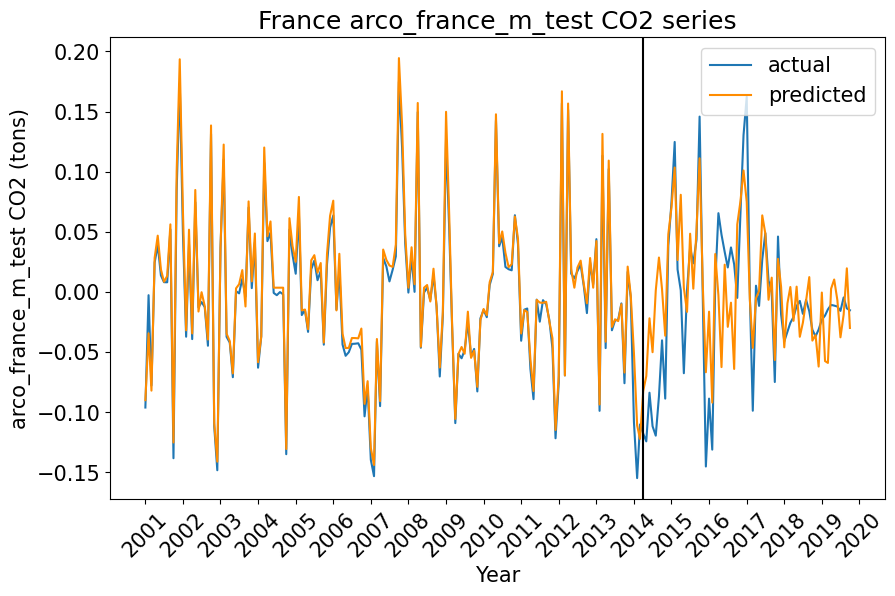

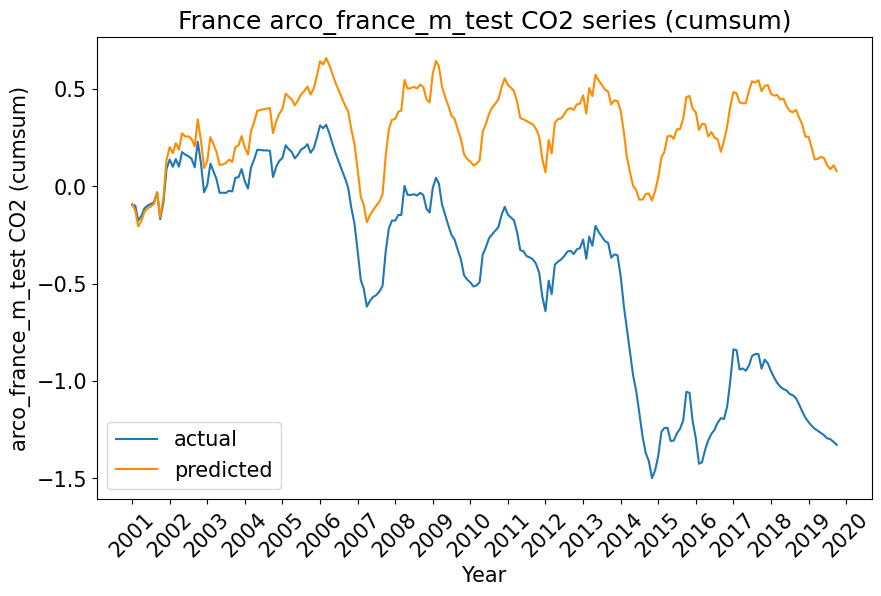

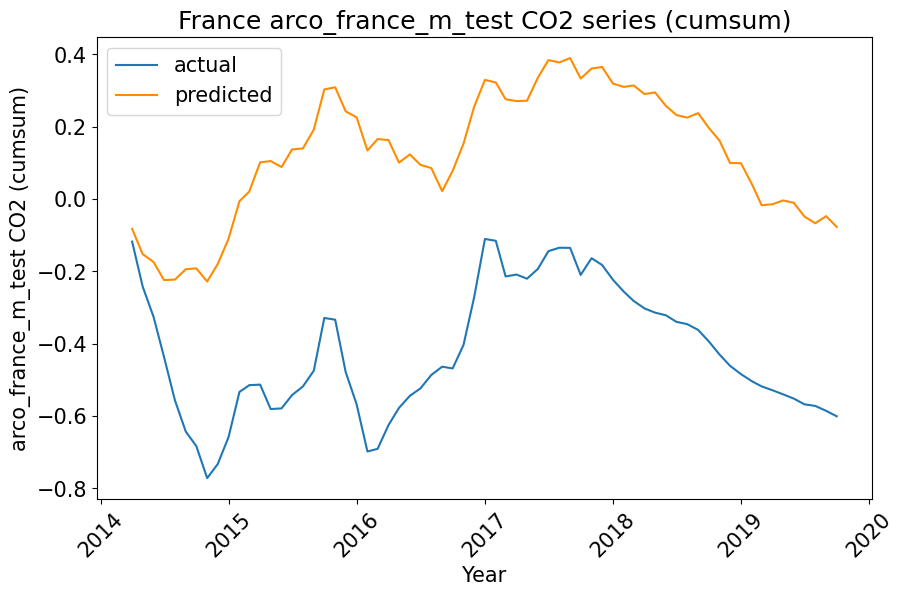

In [170]:
act_log_diff = np.array(y_log_diff).reshape(-1,1)
pred_log_diff = flatten(SS_treatmentfit_pre.inverse_transform(np.array(net.predict(sm.add_constant(X_log_diff_stand))).reshape(-1,1)))
act_pred_log_diff = pd.DataFrame(list(zip(act_log_diff, pred_log_diff)),
                                         columns=['act', 'pred']).set_index(treatment_log_diff.index)
act_pred_log_diff['error'] = act_pred_log_diff['act'] - act_pred_log_diff['pred']

var_name = f'{model}_{treatment_country}_{timeframe}_test'
plot_predictions(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
plot_cumsum(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
plot_cumsum_impl(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)

# RF

In [171]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [218]:
train_y = np.array(y_log_diff_pre_stand).ravel()
train_x = X_log_diff_pre_stand

rf = RandomForestRegressor(n_estimators=10,
                          max_depth=10,
                          min_weight_fraction_leaf=0.2)
# rf = RandomForestRegressor()
rf.fit(train_x, train_y)

print(f"model score on training data: {rf.score(train_x, train_y)}")

# y = np.array(y_log_diff).reshape(-1,1)
# X = X_log_diff_stand
# X = sm.add_constant(X)
# print(f"model score on testing data: {rf.score(X, y)}")

model score on training data: 0.6299529831389516


In [248]:
for i, val in enumerate(rf.feature_importances_):
    if val != 0:
        print(donors_log_diff.columns[i], val)

austria co2 0.020767804241126824
belgium co2 0.5253860846397643
belgium ind_prod 0.0041657542400203905
croatia co2 0.0190559127867804
germany co2 0.0839815767736053
hungary co2 0.08949419568993044
italy co2 0.07115976952144736
netherlands co2 0.1714014679525049
spain co2 0.011527157359782299
spain ind_prod 0.0030602767950376345


In [257]:
coefs = {}

for i, val in enumerate(rf.feature_importances_):
    if val != 0:
        coefs[donors_log_diff.columns[i]] =  val
                   
coefs = dict(sorted(coefs.items(), key=lambda item: item[1], reverse=True))
list(coefs.values())

[0.5253860846397643,
 0.1714014679525049,
 0.08949419568993044,
 0.0839815767736053,
 0.07115976952144736,
 0.020767804241126824,
 0.0190559127867804,
 0.011527157359782299,
 0.0041657542400203905,
 0.0030602767950376345]

In [232]:
coefs = list(rf.feature_importances_)
coefs

[0.0,
 0.020767804241126824,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5253860846397643,
 0.0,
 0.0041657542400203905,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0190559127867804,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0839815767736053,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.08949419568993044,
 0.0,
 0.0,
 0.07115976952144736,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1714014679525049,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.011527157359782299,
 0.0030602767950376345,
 0.0,
 0.0]

In [236]:
coefs_index = [i for i, val in enumerate(rf.feature_importances_) if val != 0]
coefs_index

# coefs_index2 = np.argsort(rf.feature_importances_)
# coefs_index2

[1, 6, 8, 18, 28, 36, 39, 49, 67, 68]

In [241]:
pars = list(donors_log_diff.columns[coefs_index])
pars

['austria co2',
 'belgium co2',
 'belgium ind_prod',
 'croatia co2',
 'germany co2',
 'hungary co2',
 'italy co2',
 'netherlands co2',
 'spain co2',
 'spain ind_prod']

In [220]:
coefs_index = [i for i, val in enumerate(coefs) if val != 0]
coefs_index

[1, 6, 8, 18, 28, 36, 39, 49, 67, 68]

In [221]:
n_pars = len(coefs_index)
n_pars

10

In [222]:
pars = list(donors_log_diff.columns[coefs_index])
pars

['austria co2',
 'belgium co2',
 'belgium ind_prod',
 'croatia co2',
 'germany co2',
 'hungary co2',
 'italy co2',
 'netherlands co2',
 'spain co2',
 'spain ind_prod']

In [224]:
coefs = [round(coef, 3) for coef in coefs if coef != 0]
coefs

[0.021, 0.525, 0.004, 0.019, 0.084, 0.089, 0.071, 0.171, 0.012, 0.003]

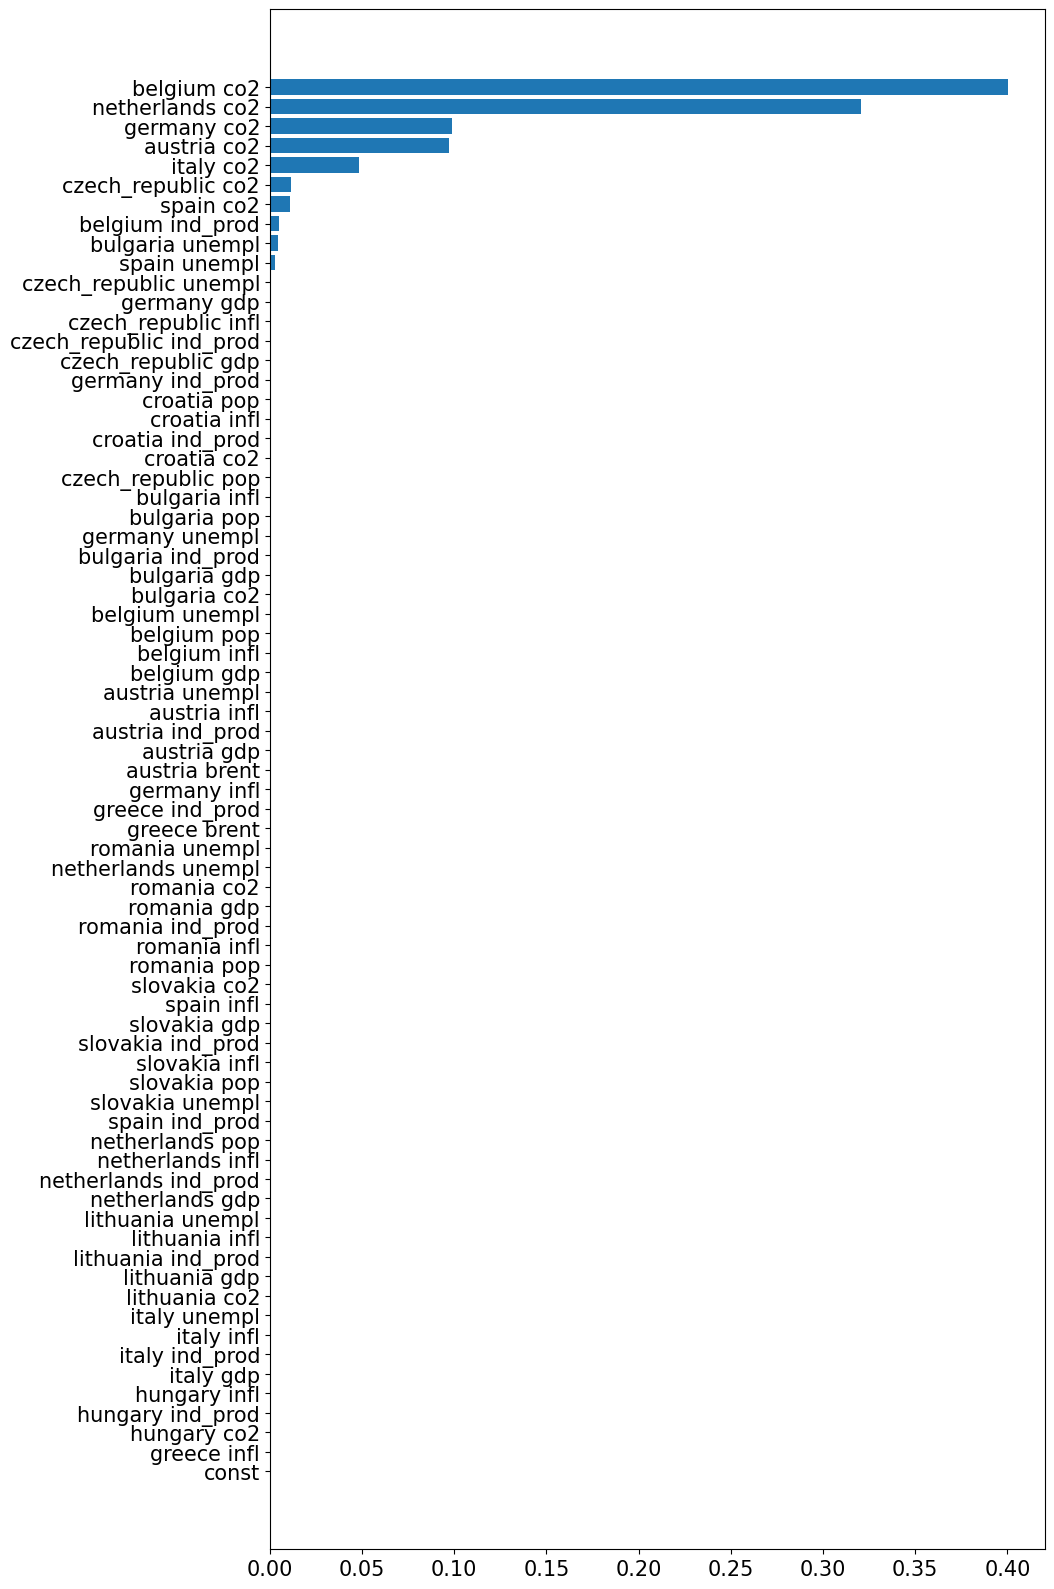

In [173]:
importances = rf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,20))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(train_x.columns)[indices])

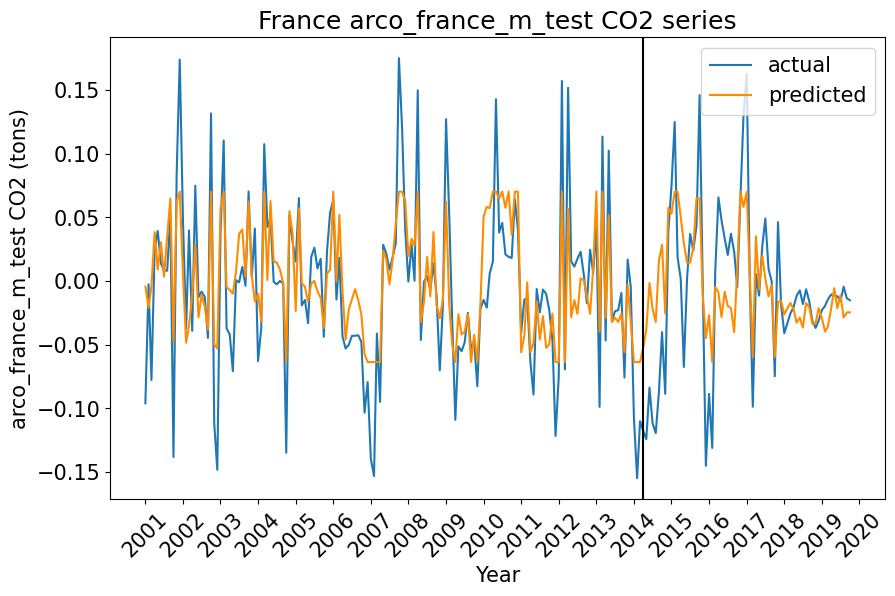

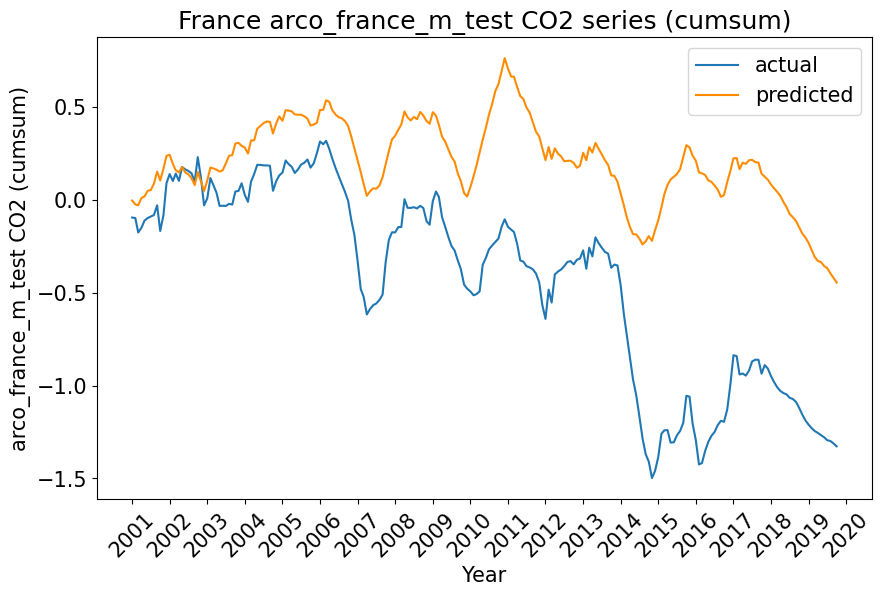

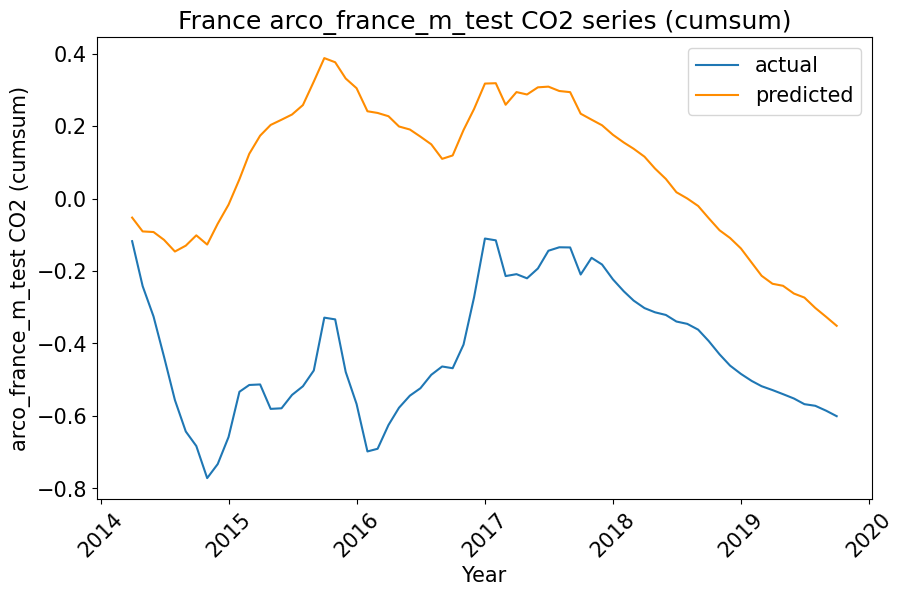

In [174]:
act_log_diff = np.array(y_log_diff).reshape(-1,1)
pred_log_diff = flatten(SS_treatmentfit_pre.inverse_transform(np.array(rf.predict(sm.add_constant(X_log_diff_stand))).reshape(-1,1)))
act_pred_log_diff = pd.DataFrame(list(zip(act_log_diff, pred_log_diff)),
                                         columns=['act', 'pred']).set_index(treatment_log_diff.index)
act_pred_log_diff['error'] = act_pred_log_diff['act'] - act_pred_log_diff['pred']

var_name = f'{model}_{treatment_country}_{timeframe}_test'
plot_predictions(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
plot_cumsum(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)
plot_cumsum_impl(df=act_pred_log_diff, treatment_country=treatment_country, timeframe=timeframe, var_name=var_name, model=model)